In [1]:
import sys
sys.path.append('./code')
sys.path.append('./data')

from clustering import *


np.random.seed(1)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['axes.linewidth'] = 1.5

In [2]:
def do_one_test(Xt,trueLabels, nStates, nClustMax,nEM):
   # tt, qq = generateChains(nStates, nClusters) # randomly generate chains
   # mixtureProbs = np.repeat(1 / nClusters, nClusters)  # uniform for now
    #Xt, trueLabels = generateTrajectories(N, T, mixtureProbs, qq, tt) # sample 

    zHat, muHat, qHat, pHat, steps, logL = doVEMmulti(Xt, nClustMax, nStates, nEM=nEM)

    best_assignment, zHat_c, qHat_c, muHat_c, pHat_c = find_best_clustermatch(trueLabels.T, zHat, muHat, qHat, pHat)  # uses HUNGARIAN ALGORITHM to assign best permutation
    
    predictLabels = zHat_c.argmax(axis=1)
    N, nClusters = np.shape(zHat)    
    #zTrue = np.zeros((N, nClusters))
    #zTrue[np.arange(N),trueLabels.T]=1

    #diffZhat = np.linalg.norm(zTrue-zHat_c, axis=1, ord=1)/2.0

    class_acc = sum(trueLabels==predictLabels)/N;

    #rand_error = adjusted_rand_score(trueLabels,predictLabels)
    return [class_acc,  logL]


In [3]:
T=50
N=100
nClustMax=15
nStates=7
nClusters=10


In [4]:
tt, qq = generateChains(nStates, nClusters) # randomly generate chains
mixtureProbs = np.repeat(1 / nClusters, nClusters)  # uniform for now
Xt, trueLabels = generateTrajectories(N, T, mixtureProbs, qq, tt) # sample 


In [5]:
from joblib import Parallel, delayed

nEM=1
nSims=1000

results = Parallel(n_jobs=-1)(delayed(do_one_test)(Xt,trueLabels, nStates, nClustMax,nEM) for _ in range(nSims))
npresults = np.array(results)


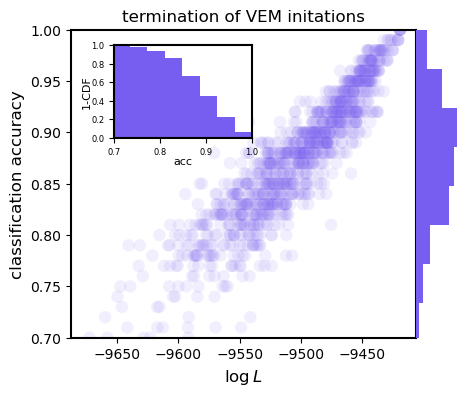

In [6]:
colors = np.array(['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000'])
fig=plt.figure(figsize=(5, 4))

gs = fig.add_gridspec(1,2,  width_ratios=(8, 1),
                      wspace=0.00, hspace=0.0)


ax_scatter = fig.add_subplot(gs[0, 0])

ax_scatter.scatter(npresults[:,1],npresults[:,0],s=80,alpha=0.1,color=colors[1],edgecolors='none')
ax_scatter.set_ylabel('classification accuracy',fontsize=12)
ax_scatter.set_xlabel('$\\log L$',fontsize=12)
ax_scatter.set_title("termination of VEM initations")
ax_scatter.set_ylim([0.7,1.0])


axin1 = ax_scatter.inset_axes([0.125, 0.65, 0.4, 0.3])

axin1.hist(npresults[:,0],cumulative=-1,density=True,color=colors[1])
axin1.set_ylabel('1-CDF',labelpad=0,fontsize=8)

axin1.set_xlabel('acc',labelpad=0,fontsize=8)
axin1.tick_params(axis='both', which='major', labelsize=6)

axin1.set_xlim([0.7,1.0])
axin1.set_ylim([0,1])


ax_histy  = fig.add_subplot(gs[0, 1],sharey=ax_scatter)
ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.set_axis_off()
ax_histy.hist(npresults[:,0],orientation='horizontal',color=colors[1])
fig.savefig("figs/EMlocal.pdf", format="pdf")